# 01 Importing Libraries

In [59]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [60]:
# Configure API key 

quandl.ApiConfig.api_key = '7LoRa7srzy7mTnLvNfE9'

# 02 Import Data

In [61]:
# Importing the Federal Reserve Economic Data "Natural Rate of Unemployment" variable.

data = quandl.get('FRED/NROUST')

In [62]:
data.head()

,Value
Date,
1949-01-01,5.255053
1949-04-01,5.261516
1949-07-01,5.268013
1949-10-01,5.274564
1950-01-01,5.281182


In [63]:
data.shape

(332, 1)

In [64]:
data.columns

Index(['Value'], dtype='object')

In [65]:
type(data)

pandas.core.frame.DataFrame

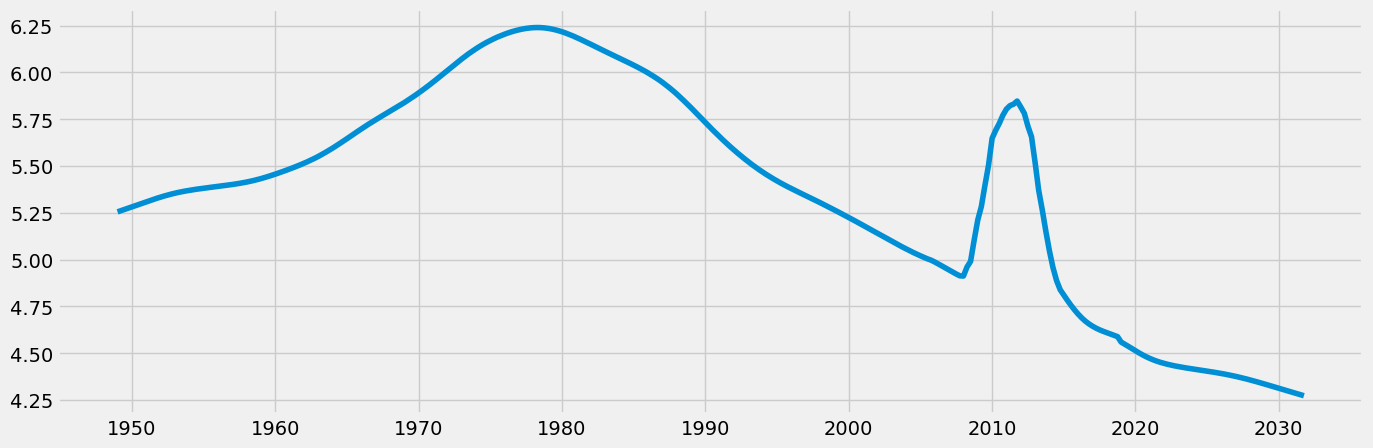

In [66]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

In [67]:
data.tail()

,Value
Date,
2030-10-01,4.294982
2031-01-01,4.289282
2031-04-01,4.283630
2031-07-01,4.278029
2031-10-01,4.272470


# 03 Subset your Data

In [68]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [69]:
data_2.head()

,Date,Value
0,1949-01-01,5.255053
1,1949-04-01,5.261516
2,1949-07-01,5.268013
3,1949-10-01,5.274564
4,1950-01-01,5.281182


In [70]:
data_sub = data_2.loc[(data_2['Date'] >= '1990-01-01') & (data_2['Date'] < '2023-01-01')]

In [71]:
data_sub.shape

(132, 2)

In [72]:
data_sub.head()

,Date,Value
164,1990-01-01,5.732765
165,1990-04-01,5.713231
166,1990-07-01,5.693902
167,1990-10-01,5.674851
168,1991-01-01,5.656146


In [73]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
1990-01-01,5.732765
1990-04-01,5.713231
1990-07-01,5.693902
1990-10-01,5.674851
1991-01-01,5.656146


# 04 Create a Line Chart

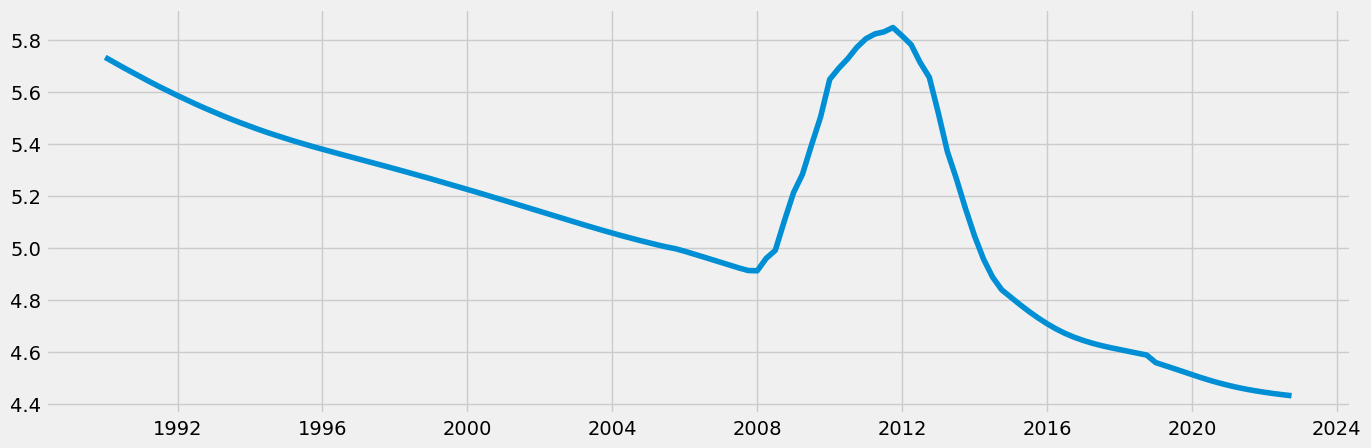

In [74]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [75]:
# Check for missing values (you shouldn't have any)

data_sub.isnull().sum() 

Value    0
dtype: int64

In [76]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

0

# 05 Decompose the Components

In [78]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [79]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

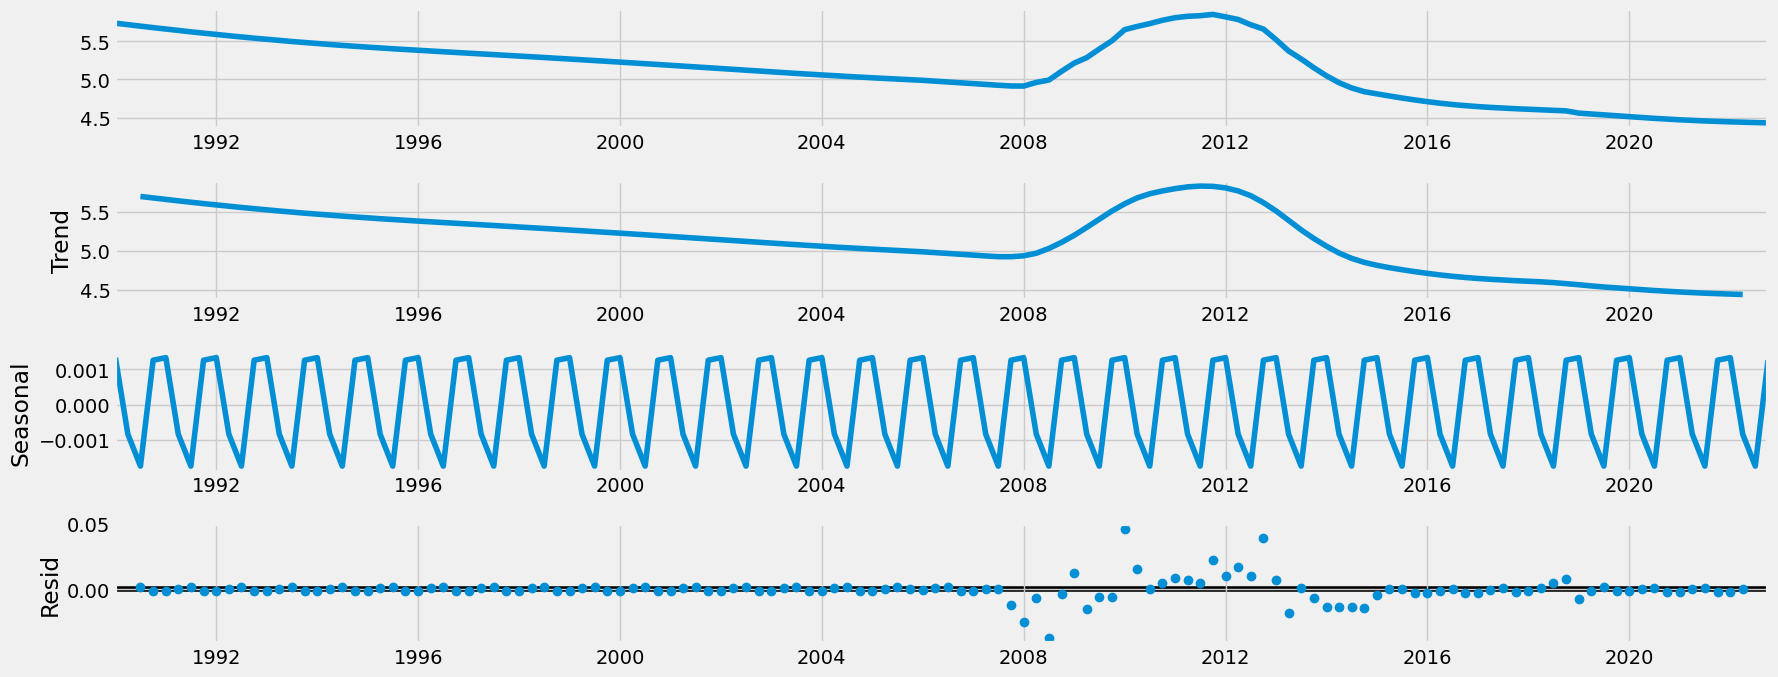

In [80]:
# Plot the separate components

decomposition.plot()
plt.show()

# 06 Conduct Dickey-Fuller Test
To check for stationarity

In [81]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -0.623713
p-value                          0.865533
Number of Lags Used             12.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


#### Test Statistic is larger than critical value = can't reject null hypothesis.

# 07 Stationarizing Data

In [82]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [83]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [84]:
data_diff.head()

,Value
datetime,
1990-04-01,-0.019534
1990-07-01,-0.019328
1990-10-01,-0.019051
1991-01-01,-0.018706
1991-04-01,-0.018308


In [85]:
data_diff.columns

Index(['Value'], dtype='object')

In [ ]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

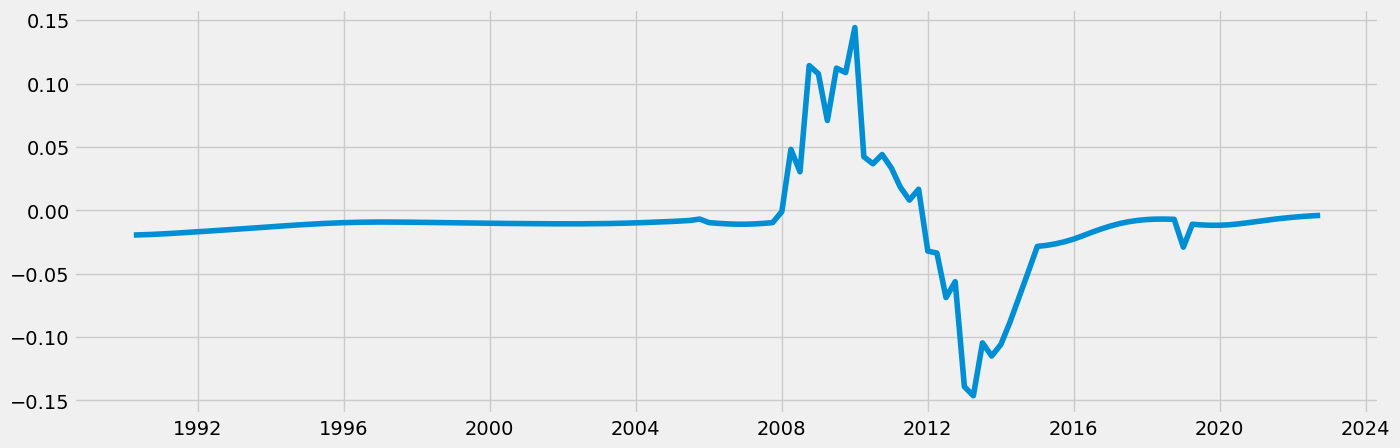

In [86]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [87]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -4.191261
p-value                          0.000682
Number of Lags Used             11.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


### Test Statistic is smaller than the critical value = can reject nully hypothesis

# 09 Check Auto Correlations

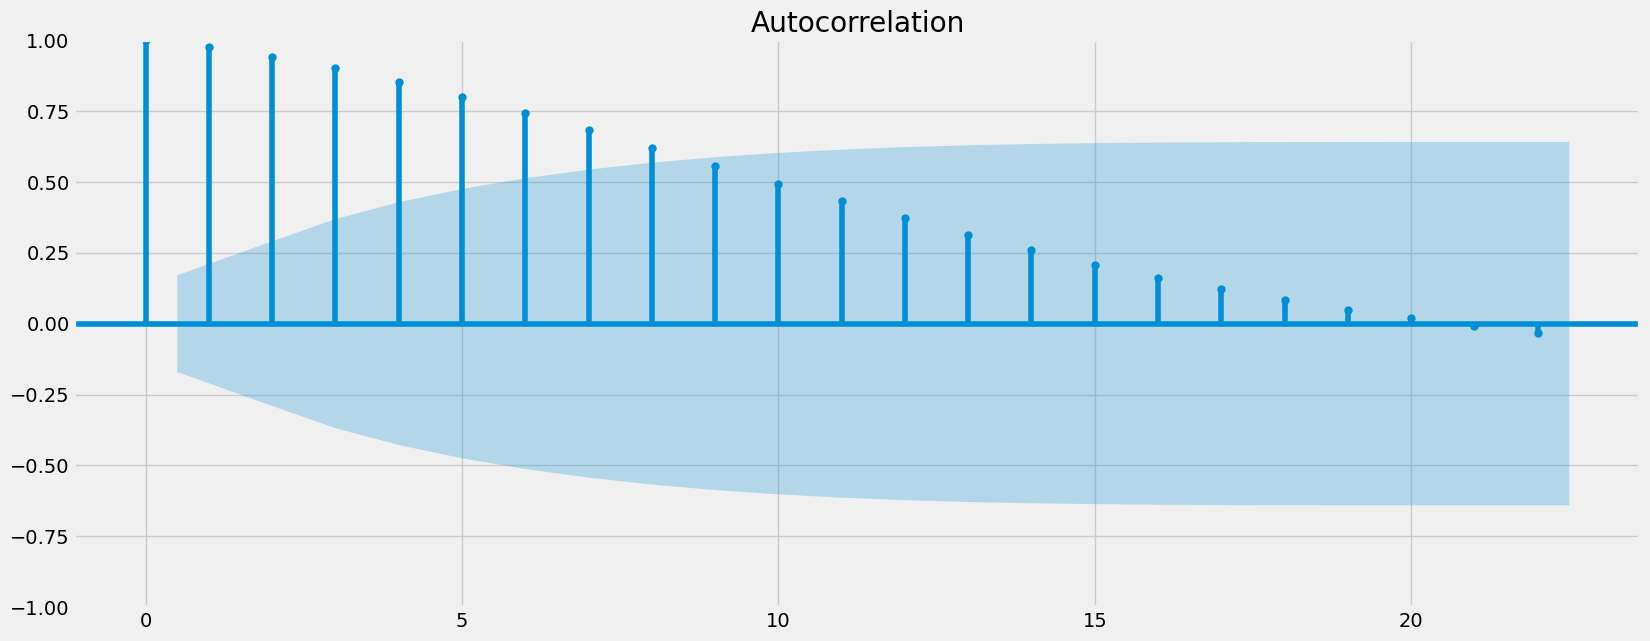

In [90]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

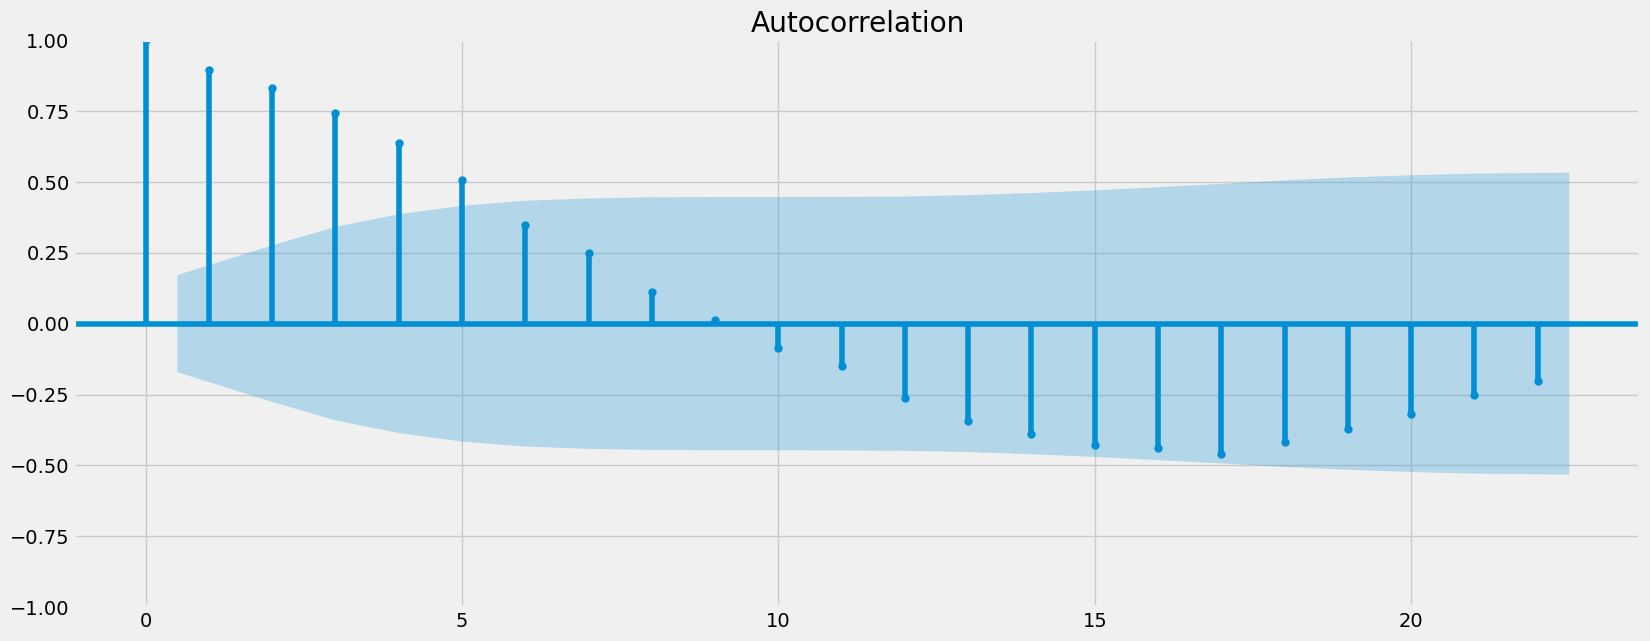

In [91]:
plot_acf(data_diff)
plt.show()